In [1]:
#import sccoda

In [2]:
import seaborn 

In [3]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap

from anndata import AnnData
from typing import Optional, Tuple, Collection, Union, List

In [5]:
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [6]:
#from sccoda.util import comp_ana as mod
#from sccoda.util import cell_composition_data as dat
#from sccoda.util import data_visualization as viz

#import sccoda.datasets as scd

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from statannotations.Annotator import Annotator

In [9]:
#from statannotations.Annotator import Annotator

In [10]:
adata = sc.read_h5ad("data_all.h5ad")

In [11]:
adata

AnnData object with n_obs × n_vars = 24 × 9
    obs: 'condition', 'sample_id'

In [12]:
adata = adata[adata.obs["condition"].isin(["10mix","11mix"])]

In [13]:
adata.var.index

Index(['SLEC_Ifn', 'MPEC_Progenitor', 'MPEC_Intermediate', 'MPEC_Effector',
       'SLEC_Plastic', 'SLEC_Effector', 'SLEC_Intermediate', 'SLEC_Progenitor',
       'SLEC_Terminal'],
      dtype='object', name='cell_type')

In [14]:
#plot_df

In [15]:
adata_11 = adata[adata.obs["condition"]=="11mix"]

In [16]:
adata_10 = adata[adata.obs["condition"]=="10mix"]

In [17]:
def boxplots(
        data: AnnData,
        feature_name: str,
        y_scale: str = "relative",
        plot_facets: bool = False,
        add_dots: bool = False,
        cell_types: Optional[list] = None,
        args_boxplot: Optional[dict] = {},
        args_swarmplot: Optional[dict] = {},
        figsize: Optional[Tuple[int, int]] = None,
        dpi: Optional[int] = 100,
        cmap: Optional[str] = "Blues",
        plot_legend: Optional[bool] = True,
        level_order: List[str] = None
) -> Optional[Tuple[plt.Subplot, sns.axisgrid.FacetGrid]]:
    """\
    Grouped boxplot visualization. The cell counts for each cell type are shown as a group of boxplots,
    with intra--group separation by a covariate from data.obs.

    The cell type groups can either be ordered along the x-axis of a single plot (plot_facets=False) or as plot facets (plot_facets=True).

    Parameters
    ----------
    data
        A scCODA-compatible data object
    feature_name
        The name of the feature in data.obs to plot
    y_scale
        Transformation to of cell counts. Options: "relative" - Relative abundance, "log" - log(count), "count" - absolute abundance (cell counts)
    plot_facets
        If False, plot cell types on the x-axis. If True, plot as facets
    add_dots
        If True, overlay a scatterplot with one dot for each data point
    cell_types
        Subset of cell types that should be plotted
    args_boxplot
        Arguments passed to sns.boxplot
    args_swarmplot
            Arguments passed to sns.swarmplot
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The seaborn color map for the barplot
    plot_legend
        If True, adds a legend
    level_order
        Custom ordering of bars on the x-axis

    Returns
    -------
    Depending on `plot_facets`, returns a :class:`~plt.AxesSubplot` (`plot_facets = False`) or :class:`~sns.axisgrid.FacetGrid` (`plot_facets = True`) object

    ax
        if `plot_facets = False`
    g
        if `plot_facets = True`
    """

    # y scale transformations
    if y_scale == "relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = data.X/sample_sums
        value_name = "Proportion"
    # add pseudocount 1 if using log scale (needs to be improved)
    elif y_scale == "log":
        X = np.log(data.X + 1)
        value_name = "log(count)"
    elif y_scale == "count":
        X = data.X
        value_name = "count"
    else:
        raise ValueError("Invalid y_scale transformation")

    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    if cell_types is not None:
        plot_df = plot_df[plot_df["Cell type"].isin(cell_types)] 
    if plot_facets:

        if level_order is None:
            level_order = pd.unique(plot_df[feature_name])

        K = X.shape[1]

        g = sns.FacetGrid(
            plot_df,
            col="Cell type",
            sharex=False,
            col_wrap=int(np.floor(np.sqrt(K))),
            height=5,
            aspect=2,
        )
        g.map(
            sns.boxplot,
            value_name,
            feature_name,
            palette=cmap,
            order=level_order,
            **args_boxplot
        )
        for ax in g.axes.flat:
            cell_type = ax.get_title().split(' = ')[-1]
            sub_df = plot_df[plot_df["Cell type"] == cell_type]


        if add_dots:

            if "hue" in args_swarmplot:
                hue = args_swarmplot.pop("hue")
            else:
                hue = None

            if hue is None:
                g.map(
                    sns.swarmplot,
                    value_name,
                    feature_name,
                    color="black",
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
            else:
                g.map(
                    sns.swarmplot,
                    value_name,
                    feature_name,
                    hue,
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
        # Remove frame (spines)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        return g

    else:

        if level_order:
            args_boxplot["hue_order"] = level_order
            args_swarmplot["hue_order"] = level_order

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.boxplot(y="Cell type", x=value_name, hue=feature_name, data=plot_df, fliersize=1,
                    palette=cmap, ax=ax, **args_boxplot)
    


        if add_dots:
            sns.swarmplot(
                y="Cell type",
                x=value_name,
                data=plot_df,
                hue=feature_name,
                ax=ax,
                dodge=True,
                color="black",
                **args_swarmplot
            )

        cell_types = pd.unique(plot_df["Cell type"])
        ax.set_yticklabels(cell_types)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

        # Invert x-axis
        #ax.set_xlim(ax.get_xlim()[::-1])

        if plot_legend:
            handles, labels = ax.get_legend_handles_labels()
            handout = []
            labelout = []
            for h, l in zip(handles, labels):
                if l not in labelout:
                    labelout.append(l)
                    handout.append(h)
          #  ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

        plt.tight_layout()

        return ax


<Axes: xlabel='Proportion', ylabel='Cell type'>

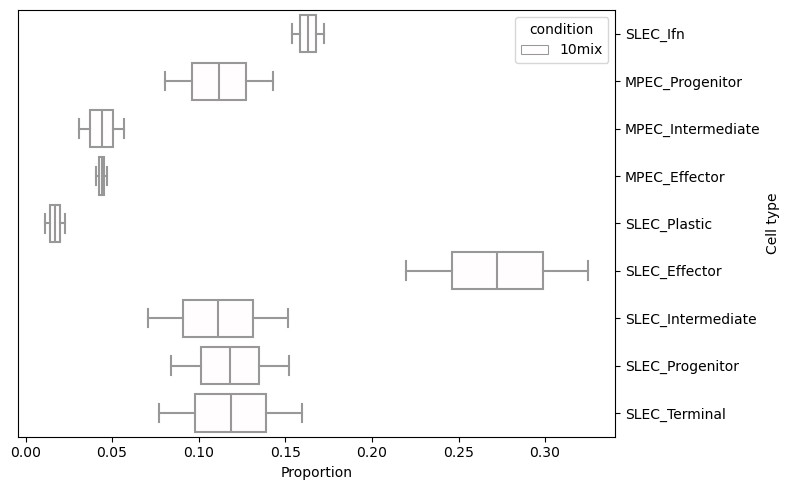

In [18]:
boxplots(adata_10, feature_name="condition", cmap="seismic",figsize=(8, 5), plot_facets=False)

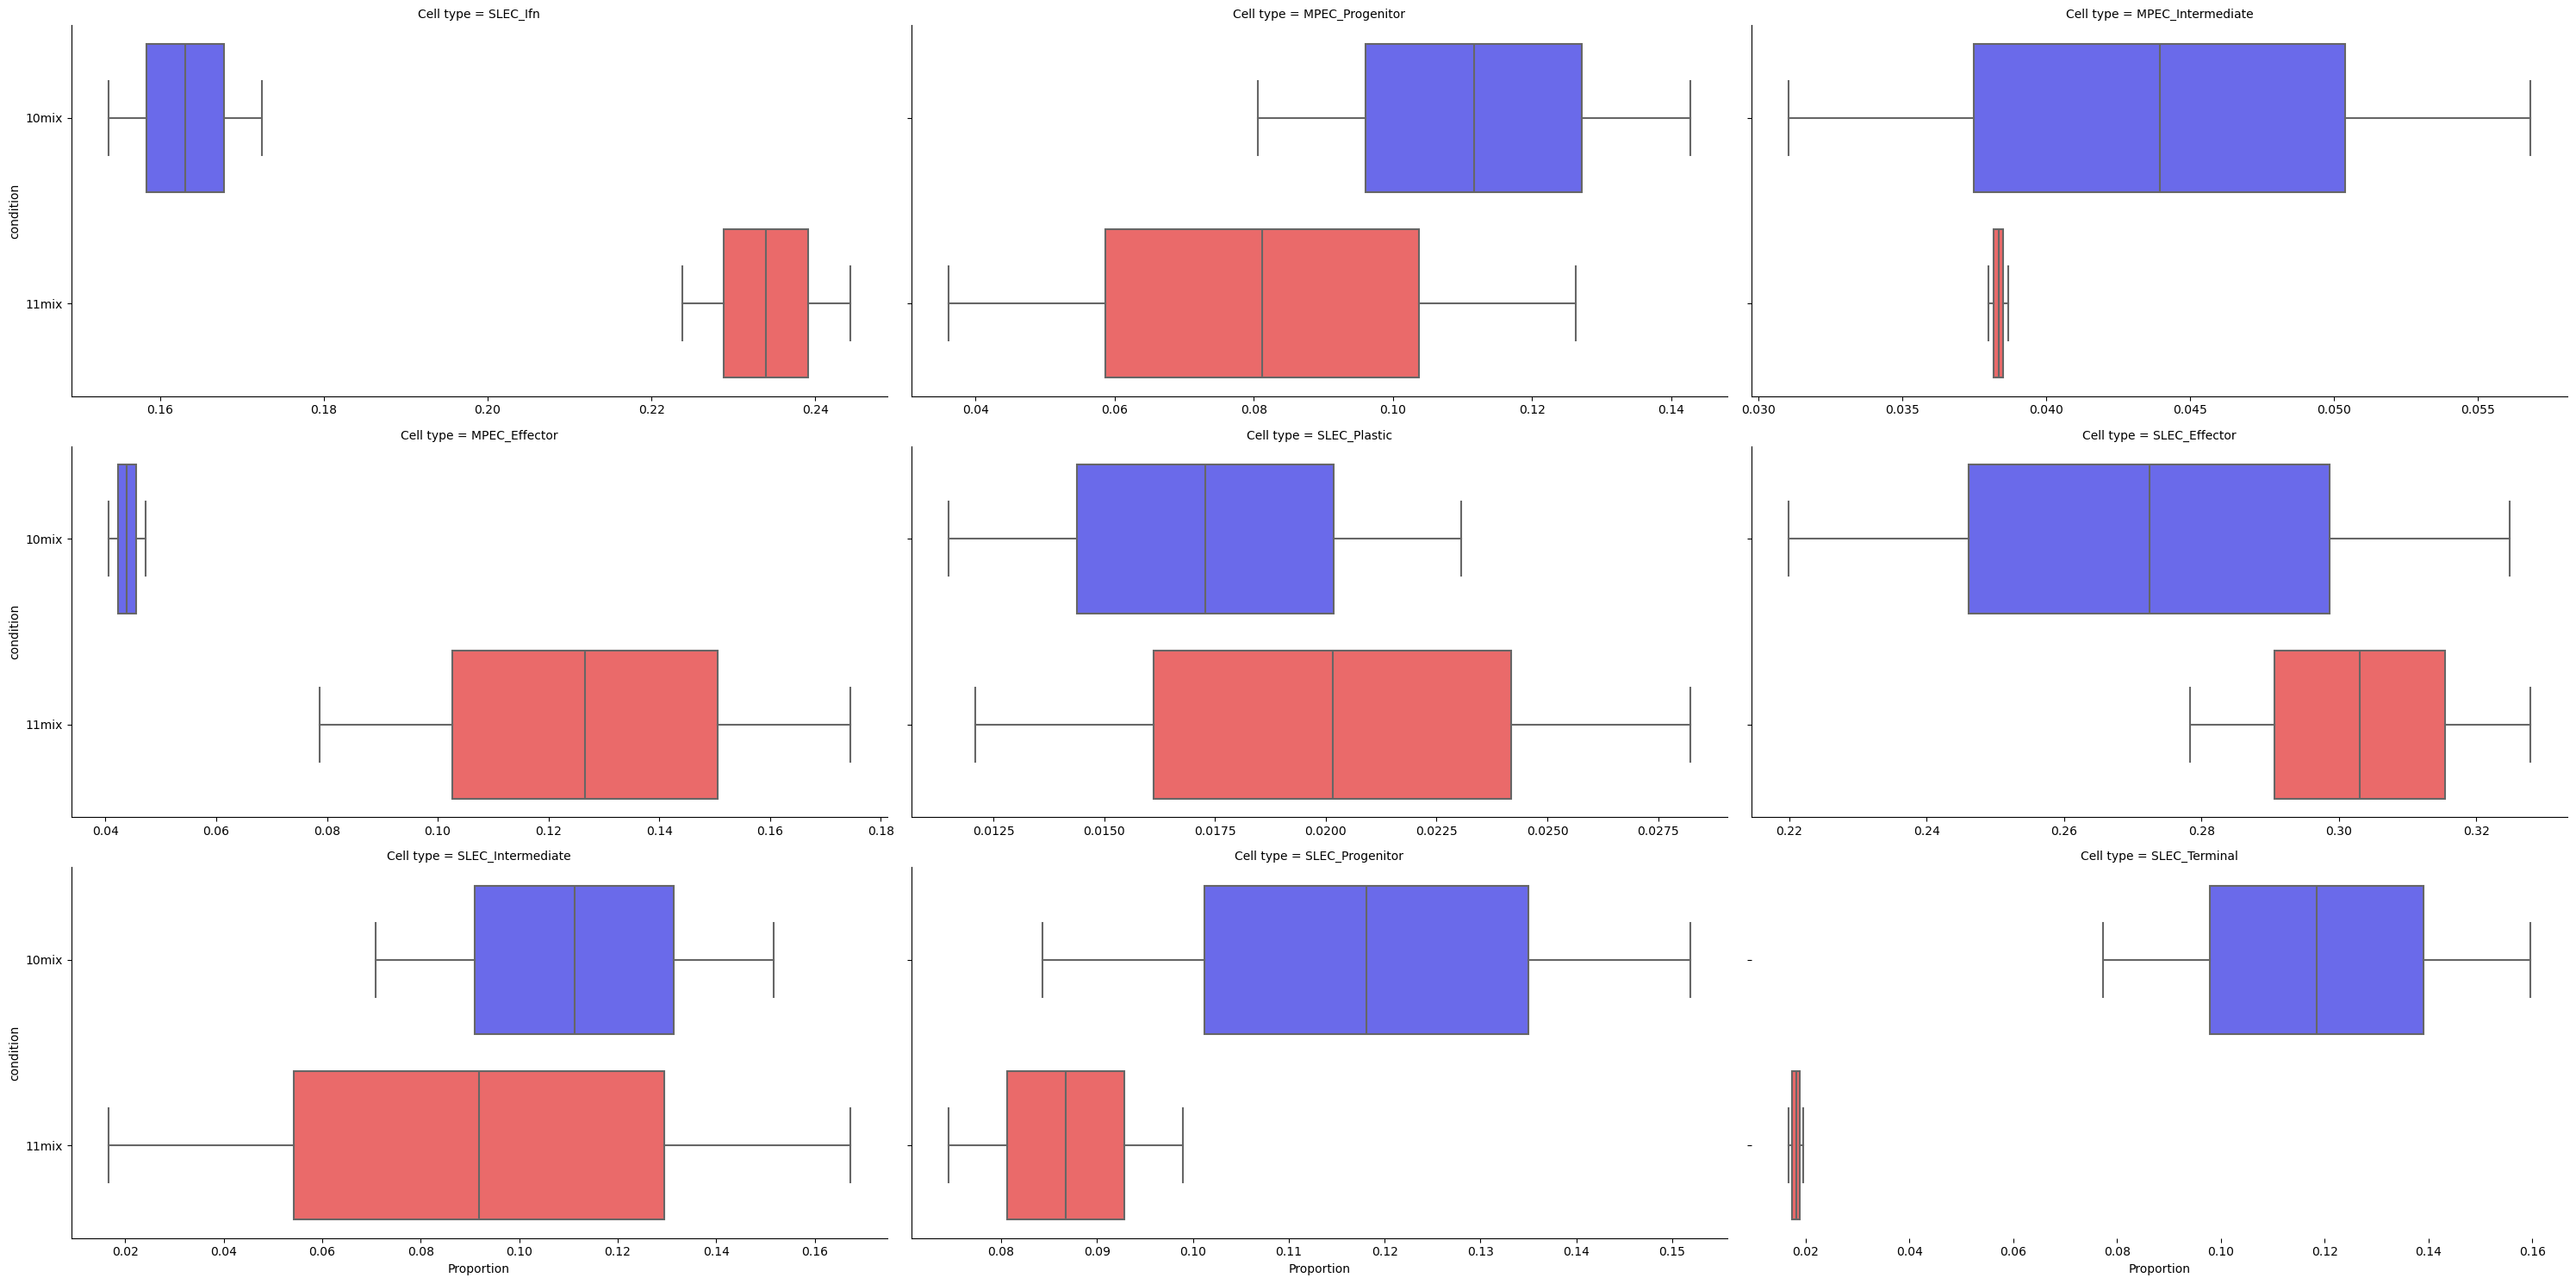

In [19]:
boxplots(adata, feature_name="condition", figsize=(12, 5), cmap = "seismic", plot_facets=True)


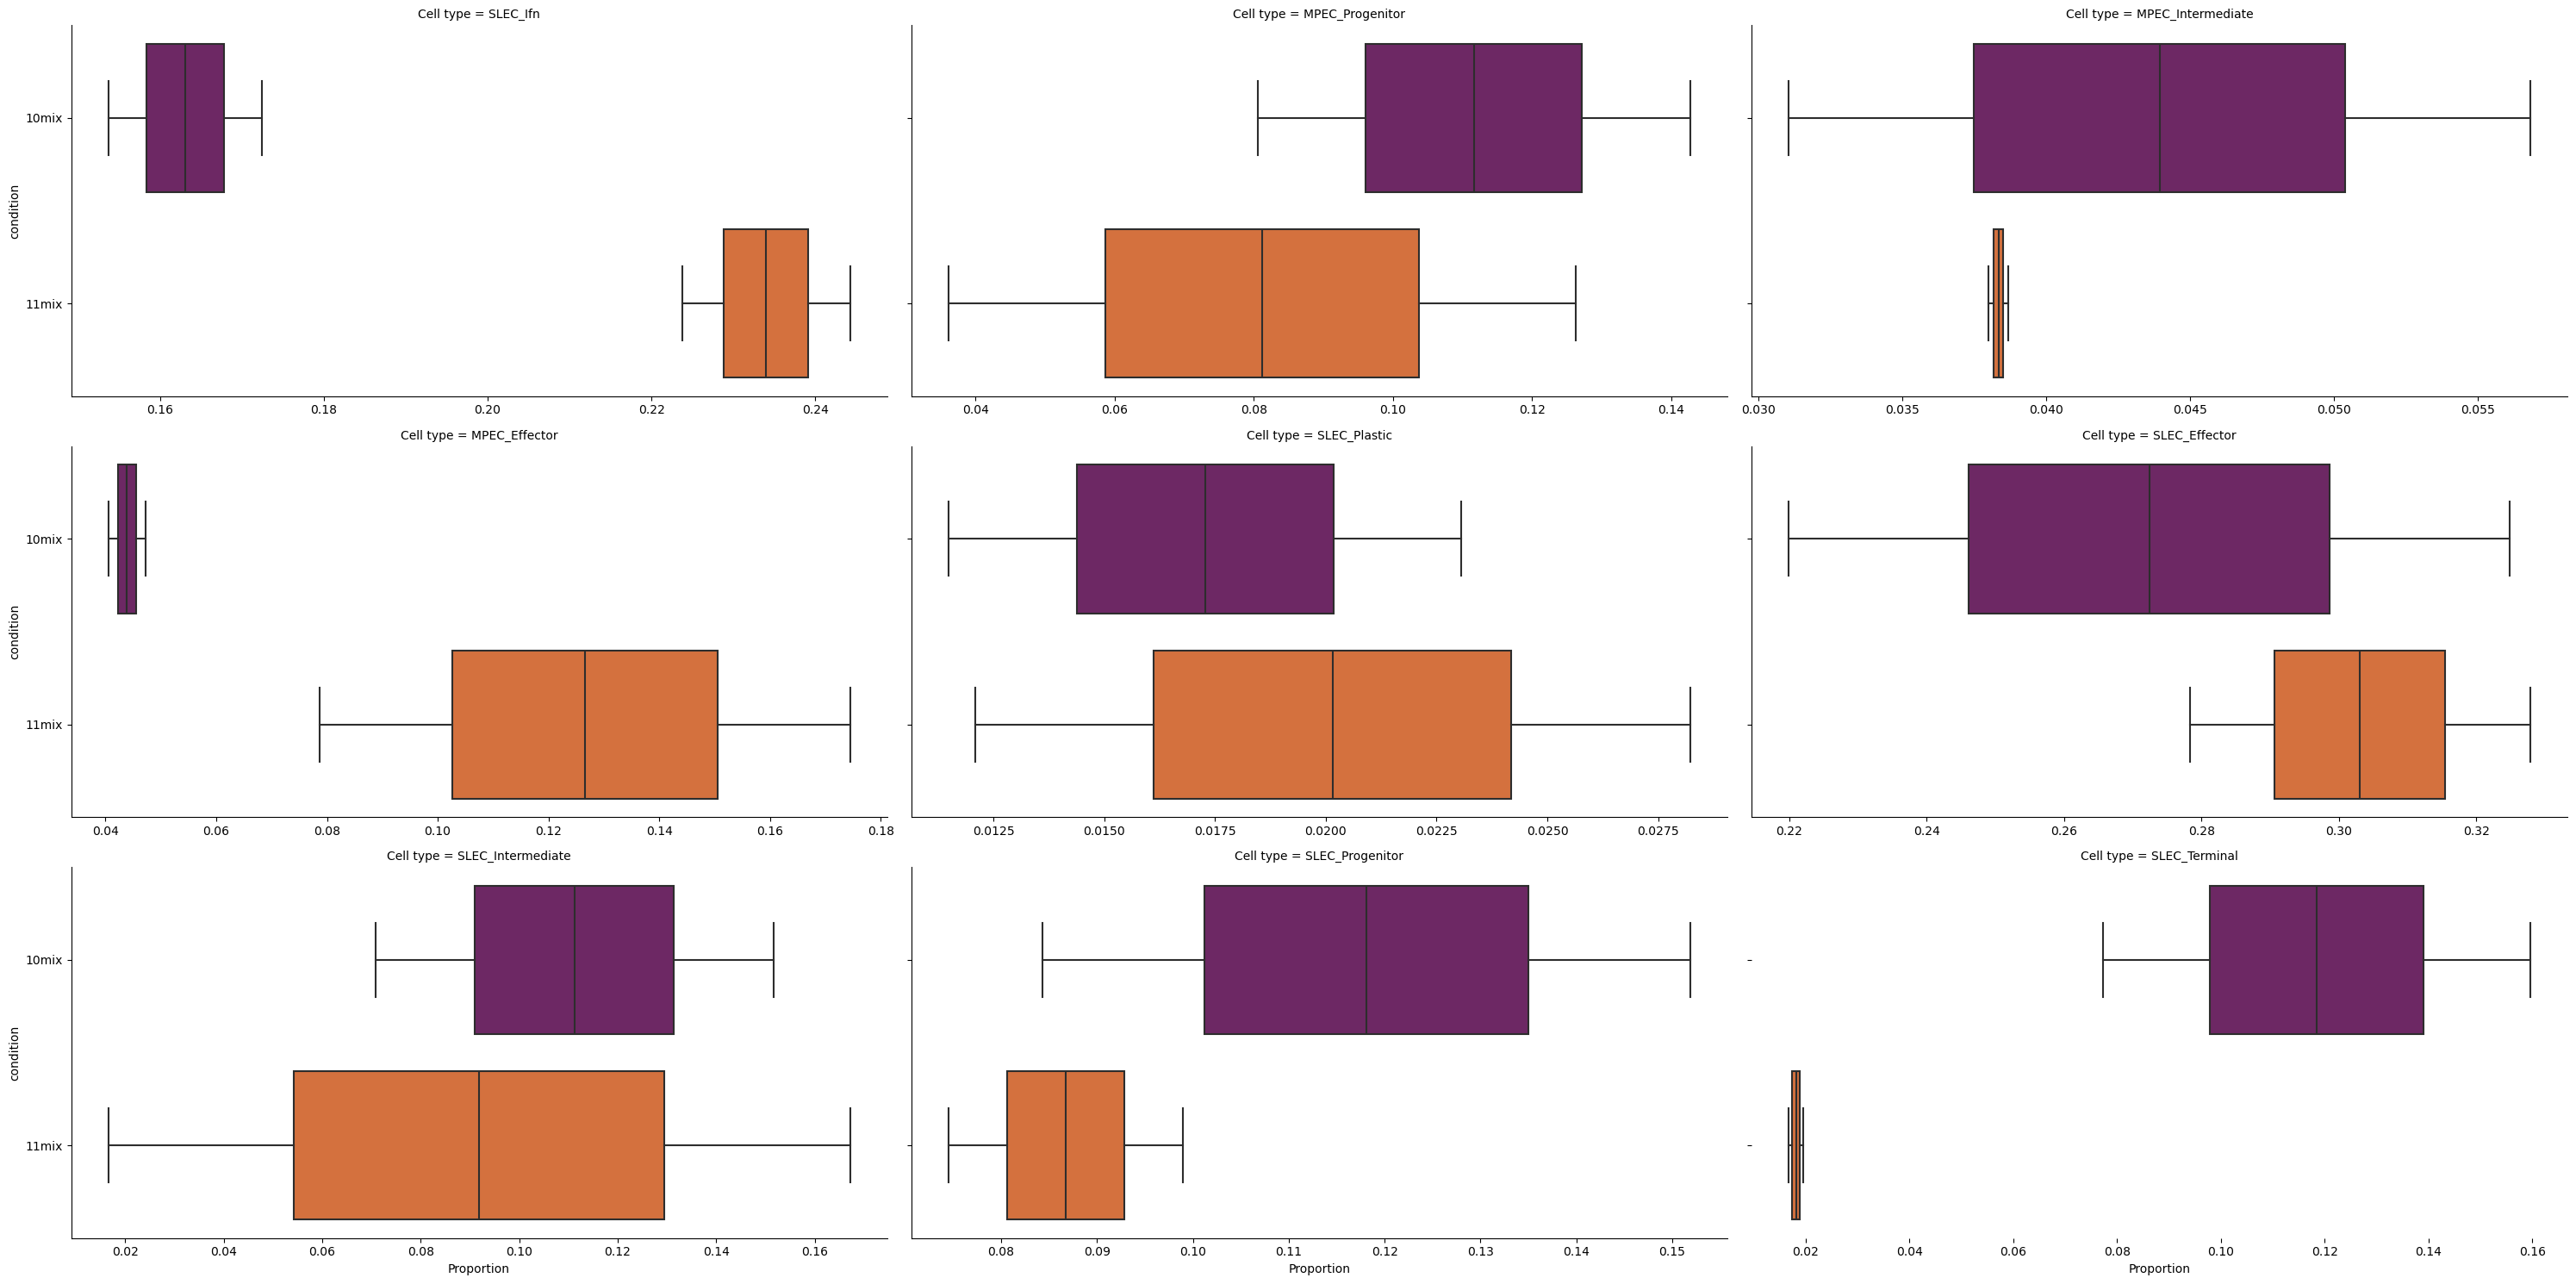

In [26]:
boxplots(adata, feature_name="condition", figsize=(8, 5), cmap = "inferno", plot_facets=True, save = )


<Axes: xlabel='Proportion', ylabel='Cell type'>

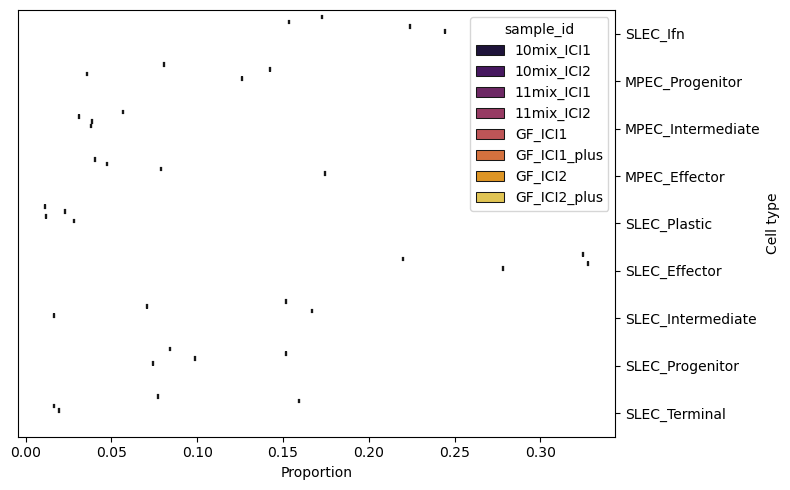

In [25]:
boxplots(adata, feature_name="sample_id", figsize=(8, 5), cmap = "inferno", plot_facets=False)


In [27]:
viz.boxplots(adata, feature_name="condition", figsize=(8, 5), cmap = "inferno", plot_facets=True)


NameError: name 'viz' is not defined